# LIBRERIAS

In [1]:
## Flow Hydro Consulting SpA - 2023

## Importar librerias

from cmath import isnan
import pandas as pd
import numpy as np
from sklearn import linear_model
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


# Ruta data de referencia

In [2]:
# Se indica la ruta junto con el nombre el archivo .csv
# Se tiene que cargar la data del mes con 0 en los datos que se quieren rellenar
ruta = "C:/Users/CamZuniga/SQM Industrial S.A/SI RAySH-GHS - Documentos/24 Validaciones/01 Validación Meteorología Continua/04 Valmeteo/Codigos/DATA.csv"
rutaSalida = "C:/Users/CamZuniga/SQM Industrial S.A/SI RAySH-GHS - Documentos/24 Validaciones/01 Validación Meteorología Continua/04 Valmeteo/2024/07 JUL/DataRellenada/"

# FUNCIONES

In [3]:
###################################### Funciones #############################################################

# Se crea un dataframe que contiana una variable meteorologica, 
# en donde las columnas son cada una de las estaciones y las filas las fechas
def createColumn( df, estacion ):
    if not estacion in df:
        df[estacion] = None
    
    return df

# Retorna el indice de la fila en que las fechas sean coincidentes
def getIndex(df,data,i):
    #df es el dataframe de la variable
    #data es el archivo csv
    #i indice
    return df.loc[df["Fecha"] == data["Fecha Medicion"][i]].index.values[0]

# Se busca la estacion con mejor correlacion para cada una de las estaciones y variables
def getMaxCorrEstationPos(param, estacion, pos ):
    # param es la variable
    # estacion corresponde a la estacion
    # pos corresponde al lugar de la correlacion ordenada de mayor a menor, 
    # ej pos=3 buscara la 3ra estacion con mejor correlacion

    paramCorr = param.iloc[:,1:] # Se omite la columna de fechas
    paramCorr = paramCorr.astype('float64').corr() #se obtienen las correlaciones

    maxCorrEstacionValue = 1 # se define la correlacion maxima

    found = True
    i = 0
    while(found==True):
        i += 1
        try:
            # Se recorre la matriz de correlacion y se obtiene la correlacion maxima tal que sea menor a 1, 
            # que no sea nulo, que se menor a la maxima correlacion anterior y mayor a 0.1
            maxCorrEstacionValue = max(item for item in paramCorr[estacion].values if ((item < 1) &
             (~np.isnan(item)) & 
             (item < maxCorrEstacionValue) &
             (item > 0.1)))
            # Indica la estacion de la mejor correlacion
            maxCorrEstacion = paramCorr.loc[paramCorr[estacion] == maxCorrEstacionValue].index.values[0]
            
            if pos == i :
                found = False
                break
        # si no se encuentra correlacion que cumpla las condiciones    
        except:
            found = False
            maxCorrEstacion = 0
   
    return maxCorrEstacion

# Se obtiene la pendiente de la regresion lineal
def getFitReg_pendiente(x, y):
    regr = linear_model.LinearRegression()
    data = {'x' : x, 'y' : y}
    xy = pd.DataFrame(data = data)
    xy = xy.dropna()
    regr.fit(xy["x"].values.reshape(-1,1), xy["y"])
    pendiente=regr.coef_[0]
    return pendiente

#Se obtiene el intercepto de la regresion lineal
def getFitReg_intercepto(x, y):
    regr = linear_model.LinearRegression()
    data = {'x' : x, 'y' : y}
    xy = pd.DataFrame(data = data)
    xy = xy.dropna()
    regr.fit(xy["x"].values.reshape(-1,1), xy["y"])
    intercepto=regr.intercept_
    return intercepto

# Se realiza el relleno a partir de los parametros de la regresion lineal
def fillWithRegresion(index,fecha,variable,estacion,maxEstacion,dataVar,data):
    # index indice del valor a rellenar
    # fecha fecha a rellenar
    # variable variable a rellenar
    # estacion estacion a rellenar
    # maxEstacion estacion con la maxima correlacion
    # dataVar dataframe de la variable a rellenar
    # data archivo csv
    
    validez = data["Validez"][index] # se consulta la validez del dato de la estacion patron
    if validez: # si es valido se realiza el relleno
        n=getFitReg_intercepto(dataVar[maxEstacion].values,dataVar[estacion].values)
        m=getFitReg_pendiente(dataVar[maxEstacion].values,dataVar[estacion].values)
        
        newIndex = dataVar.loc[dataVar["Fecha"] == fecha].index.values[0]
        newValue = m * dataVar[maxEstacion][newIndex] + n
        # Retorna el valor
        return newValue 
    else:
        return False

# Se busca la correlacion, se realiza el relleno y se asigna el valor rellenado de la estacion
def getNewValue(total,param,estacion,fecha,variable,data):
    # total numero de estaciones 
    # param dataframe de la variable a rellenar
    # estacion estacion a rellenar
    # fecha fecha a rellenar
    # variable variable a rellenar
    # data archivo csv

    # Se recorren todas las estaciones
    for j in range(1,total):
        # Se obtiene la estacion con maxima correlacion
        maxEstacion = getMaxCorrEstationPos(param,estacion,j)
        if maxEstacion == 0:
            valor = None
        else:
            try:
                # Se obtiene la posicina de la fecha,parametro y estacion a rellenar
                index = data.loc[(data["Fecha Medicion"] == fecha) & 
                (data["Nombre Parametro"] == variable) & 
                (data["Nombre Estacion"] == maxEstacion)].index.values[0]
                # Se obtiene el valor rellenado
                newValue = fillWithRegresion(index,fecha,variable,estacion,maxEstacion,param,data)
                if newValue != False:
                    valor = newValue
                    break
                    #j = total
            # Si no encuentra informacion para rellenar        
            except:
                valor=None
                maxEstacion=0
    # Retorna el valor y el nombre de la estacion
    return {"valor" : valor , "estacion" : maxEstacion}

# LECTURA DEL ARCHIVO Y CREACIÓN DE DF

In [4]:

# Se lee el archivo, se indica el delimitador del csv ("," o ";") 
# corresponde al archivo que se utilizara para crear los data frame
data = pd.read_csv(ruta,delimiter=",")

# Se lee el archivo, se indica el delimitador del csv ("," o ";") 
# corresponde al archivo que se utilizara para generar la serie con los datos rellenados
dataRellenada = pd.read_csv(ruta,delimiter=",")

# Se ordena la fecha, del mas antiguo al mas reciente
data["Nombre Parametro"].sort_values

# Se obtienen las variables meteorologicas
params = pd.DataFrame()
params["Parametro"] = data["Nombre Parametro"].unique()

# Se obtienen las fechas
dates = pd.DataFrame()
dates["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la evaporacion
evap = pd.DataFrame()
evap["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la HR
hr = pd.DataFrame()
hr["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Presion atmosferica
presAtm = pd.DataFrame()
presAtm["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Radiacion Global
radGlo = pd.DataFrame()
radGlo["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Radiacion Neta
radNet = pd.DataFrame()
radNet["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Temperatura del aire
taire = pd.DataFrame()
taire["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Velocidad del Viento
velVto = pd.DataFrame()
velVto["Fecha"] = data["Fecha Medicion"].unique()

# Se crea el dataframe que corresponde a la Direccion del Viento
dirVto = pd.DataFrame()
dirVto["Fecha"] = data["Fecha Medicion"].unique()

C:\Users\CamZuniga\AppData\Local\Temp\ipykernel_22672\600187935.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(ruta,delimiter=",")
C:\Users\CamZuniga\AppData\Local\Temp\ipykernel_22672\600187935.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dataRellenada = pd.read_csv(ruta,delimiter=",")


# RELLENO DE DF

In [5]:
# Se rellenan los data frame con los valores correspondientes al parametro, fecha y estacion
i = 0
# Se recorre cada una de las estaciones
for estacion in data["Nombre Estacion"]:
    # se obtiene el valor de la variable para cierta fecha con el indice i
    valor = data["Valor"][i]
    # en caso que se tenga otra configuracion o no se lean los valores como corresponde se puede reemplazar las "," por "."
    #valor = valor.replace(",",".") 
    #valor = float(valor)

    # Se obtiene el nombre de la estacion
    estacion = data["Nombre Estacion"][i]
    # Se obtiene la fecha
    fecha = data["Fecha Medicion"][i]

    if data["Nombre Parametro"][i] == "Evap":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de evap
        evap = createColumn(evap, estacion)
        # Se obtiene la posicion de la fecha en el data frame evap para asignar el valor que se extrae de data
        index = getIndex(evap,data,i)
        # Se asigna el valor
        evap[estacion][index] = valor
    
    elif data["Nombre Parametro"][i] == "HR prom":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de HR
        hr = createColumn(hr, estacion)
        # Se obtiene la posicion de la fecha en el data frame HR para asignar el valor que se extrae de data
        index = getIndex(hr,data,i)
        # Se asigna el valor
        hr[estacion][index] = valor
    
    elif data["Nombre Parametro"][i] == "PresAtm prom":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de presAtm
        presAtm = createColumn(presAtm, estacion)
        # Se obtiene la posicion de la fecha en el data frame presAtm para asignar el valor que se extrae de data
        index = getIndex(presAtm,data,i)
        # Se asigna el valor
        presAtm[estacion][index] = valor
    
    elif data["Nombre Parametro"][i] == "RADglobal":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de radGlo
        radGlo = createColumn(radGlo, estacion)
        # Se obtiene la posicion de la fecha en el data frame radGlo para asignar el valor que se extrae de data
        index = getIndex(radGlo,data,i)
        # Se asigna el valor
        radGlo[estacion][index] = valor

    elif data["Nombre Parametro"][i] == "RadNet":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de radNet
        radNet = createColumn(radNet, estacion)
        # Se obtiene la posicion de la fecha en el data frame radNet para asignar el valor que se extrae de data
        index = getIndex(radNet,data,i)
        # Se asigna el valor
        radNet[estacion][index] = valor

    elif data["Nombre Parametro"][i] == "T prom":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de taire
        taire = createColumn(taire, estacion)
        # Se obtiene la posicion de la fecha en el data frame taire para asignar el valor que se extrae de data
        index = getIndex(taire,data,i)
        # Se asigna el valor
        taire[estacion][index] = valor

    elif data["Nombre Parametro"][i] == "DirVto":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de dirVto
        dirVto = createColumn(dirVto, estacion)
        # Se obtiene la posicion de la fecha en el data frame dirVto para asignar el valor que se extrae de data
        index = getIndex(dirVto,data,i)
        # Se asigna el valor
        dirVto[estacion][index] = valor

    elif data["Nombre Parametro"][i] == "VelVto":
        # Si la validez del valor es 0 (falso) se asigna nulo (vacio) ya que es invalido
        if data["Validez"][i] == False :
            valor = None

        # Se crea la columna de la estacion en el data frame de velVto
        velVto = createColumn(velVto, estacion)
        # Se obtiene la posicion de la fecha en el data frame velVto para asignar el valor que se extrae de data
        index = getIndex(velVto,data,i)
        # Se asigna el valor
        velVto[estacion][index] = valor
    
    i += 1

        
i = 0
# Se obtiene el nombre de las estaciones
estaciones = data["Nombre Estacion"].unique()
# Se obtiene el numero total de estaciones 
total = estaciones.size
# Se completa la columna con Validado (luego se reemplaza con Rellenado en caso que corresponda)
dataRellenada["Observacion1"] = "Validado"
print("Calculando...")
noInfo = "No Existe Información"

# Se realiza el relleno de los datos invalidos
# Se recorren las estaciones
for estacion in data["Nombre Estacion"]:
    # Se analiza la validez del dato, se obtiene la variable y fecha
    if(data["Validez"][i] == False):
        fecha = data["Fecha Medicion"][i]
        variable = data["Nombre Parametro"][i]
    # Se recorren las variables
        if variable == "Evap":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,evap,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3) 
                #valor = str(valor).replace(".",",") # en caso que se tenga otra configuracion para los decimales
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno 
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado"
        elif variable == "HR prom":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,hr,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado" 
        elif variable == "PresAtm prom":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,presAtm,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado" 
        elif variable == "RADglobal":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,radGlo,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado" 
        elif variable == "RadNet":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,radNet,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado" 
        elif variable == "T prom":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,taire,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado"  
        elif variable == "DirVto":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,dirVto,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion
            dataRellenada.at[i,"Observacion1"] = "Rellenado" 
        elif variable == "VelVto":
            # Se obtiene el valor rellenado y la estacion patron
            res = getNewValue(total,velVto,estacion,fecha,variable,data)
            valor = res["valor"]
            estacion = res["estacion"]
            # Si se obtiene un valor se redondea a 3 decimales
            if valor != None:
                valor = round(valor,3)
                #valor = str(valor).replace(".",",")
            dataRellenada.at[i,'Valor'] = valor
            # Si no se obtiene una estacion para el relleno
            if estacion == 0:
                estacion = noInfo
            # Se completa el data frame con los valores validados y rellenado
            dataRellenada.at[i,'Observacion2'] = estacion 
            dataRellenada.at[i,"Observacion1"] = "Rellenado"
        elif variable == "NivelLis":
               dataRellenada.at[i,'Valor'] = None
               dataRellenada.at[i,'Observacion2'] = noInfo
               dataRellenada.at[i,"Observacion1"] = noInfo
        elif variable == "Prec":
               dataRellenada.at[i,'Valor'] = None
               dataRellenada.at[i,'Observacion2'] = noInfo
               dataRellenada.at[i,"Observacion1"] = noInfo
    i += 1
    # se imprime el porcentaje de avance
    print(str(round((i/data["Nombre Estacion"].size)*100,0)) + "%" )


Calculando...
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0

2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%
2.0%


3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%
3.0%


5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%
5.0%


7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%
7.0%


9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%
9.0%


11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0%
11.0

13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0%
13.0

14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
14.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0%
15.0

16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
16.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0%
17.0

18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
18.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0%
19.0

20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0

22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0%
22.0

23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0%
23.0

24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0%
24.0

25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0

25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0%
25.0

26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0%
26.0

27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0

28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0

29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0

30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0

30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
30.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0

31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0%
31.0

32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0%
32.0

33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0%
33.0

34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0%
34.0

35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0

35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
35.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0

36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0%
36.0

37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0%
37.0

38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0%
38.0

39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0%
39.0

40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0%
40.0

41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0%
41.0

42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0

42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0%
42.0

43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0%
43.0

44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0%
44.0

45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0%
45.0

46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0

47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0

47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0

48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0

49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0%
49.0

50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0

51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0%
51.0

52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0%
52.0

53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0%
53.0

54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0%
54.0

55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0

55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0%
55.0

56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0%
56.0

57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0%
57.0

58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0%
58.0

59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0%
59.0

60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0

60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
60.0%
61.0%
61.0%
61.0%
61.0%
61.0%
61.0%
61.0%
61.0

62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0%
62.0

63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0

64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0

65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0%
65.0

66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0%
66.0

67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0%
67.0

68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0

68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
68.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0%
69.0

70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0%
70.0

71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0%
71.0

73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0

73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0%
73.0

74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
74.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0

75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0

76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0

77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0%
77.0

79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0%
79.0

80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0%
80.0

81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0%
81.0

82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0%
82.0

83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0%
83.0

84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0%
84.0

85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0%
85.0

86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0%
86.0

87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0%
87.0

88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0%
88.0

89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0%
89.0

90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0%
90.0

91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0%
91.0

92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0%
92.0

93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0%
93.0

94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0%
94.0

95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0%
95.0

96.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0

97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0%
97.0

98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0%
98.0

99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0%
99.0

100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%

# CREACIÓN DE FORMATO DE ENTREGA

In [6]:

# Se eliminan las columnas Validez y Tipo de medicion
dataRellenada.drop(columns=['Validez','Tipo medición'],inplace=True)

# Se crean dos columnas Validador y Tipo de dato
dataRellenada["Validador"] = "PBI-Flow"
dataRellenada["TipoDato"]  = "Procesado"
# Se renombran las estaciones
dataRellenada.rename(columns={
    'Nombre Estacion'  : 'Estación',
    'Fecha Medicion'   : 'Fecha',
    'Nombre Parametro' : 'Variable',
    'Nombre Unidad'    : 'Unidad',
    'TipoDato'         :'Tipo de Dato',
    'Observacion1'     : 'Obs1',
    'Observacion2'     : 'Obs2'
    },inplace=True)

# Se crea el nombre del archivo
filerell = rutaSalida +'dataRellenada_'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'


# Se guarda el archivo excel con la data rellenada
dataRellenada.to_csv(filerell,encoding='utf-8-sig',index=False)



# CÁLCULO DE PARÁMETROS A RELLENAR

In [7]:
#############################################################################################
### Correlaciones 

#Se obtienen los valores y se elimina la columna fecha
evap1 = evap.iloc[:,1:]
#Se obtiene la matriz de correlacion
a1=round(evap1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'evap'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a1.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
hr1 = hr.iloc[:,1:]
#Se obtiene la matriz de correlacion
a2=round(hr1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'hr'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a2.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
presAtm1 = presAtm.iloc[:,1:]
#Se obtiene la matriz de correlacion
a3=round(presAtm1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'presAtm'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a3.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
radGlo1 = radGlo.iloc[:,1:]
#Se obtiene la matriz de correlacion
a4=round(radGlo1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'radGlo'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a4.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
taire1 = taire.iloc[:,1:]
#Se obtiene la matriz de correlacion
a5=round(taire1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'taire'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a5.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
dirVto1 = dirVto.iloc[:,1:]
#Se obtiene la matriz de correlacion
a6=round(dirVto1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'dirVto'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a6.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
velVto1 =velVto.iloc[:,1:]
#Se obtiene la matriz de correlacion
a7=round(velVto1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'velVto'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a7.to_csv(file,index=False)

#Se obtienen los valores y se elimina la columna fecha
radNet1 = radNet.iloc[:,1:]
#Se obtiene la matriz de correlacion
a8=round(radNet1.astype('float64').corr(),3)
#Se crea y guarda el archivo
file = rutaSalida+'radNet'+datetime.datetime.today().strftime('%Y_%m_%d_%H_%M') +'.csv'
a8.to_csv(file,index=False)

# Se imprime
print("Relleno terminado")
print("Archivo : "+ filerell)


Relleno terminado
Archivo : C:/Users/CamZuniga/SQM Industrial S.A/SI RAySH-GHS - Documentos/24 Validaciones/01 Validación Meteorología Continua/04 Valmeteo/2024/07 JUL/DataRellenada/dataRellenada_2024_08_14_14_56.csv


## GRÁFICO MATRICES DE CORRELACIÓN

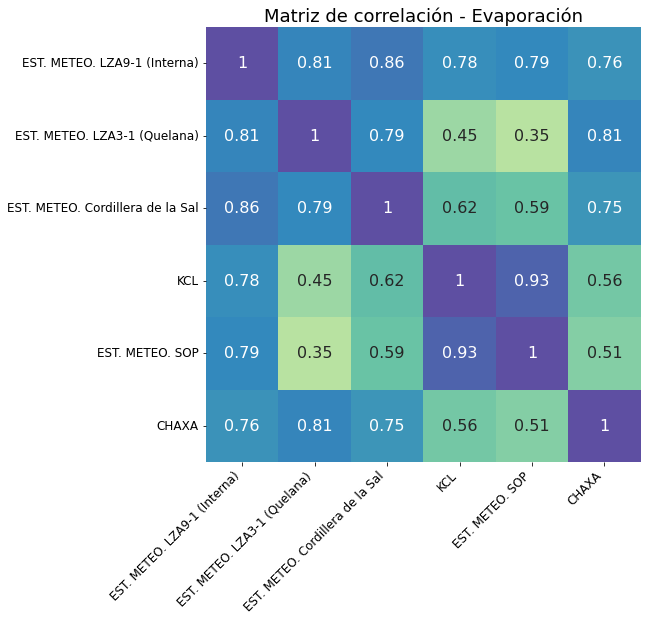

In [8]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.heatmap(
    a1,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Evaporación", size="18")
name = "MCorrEvap"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)


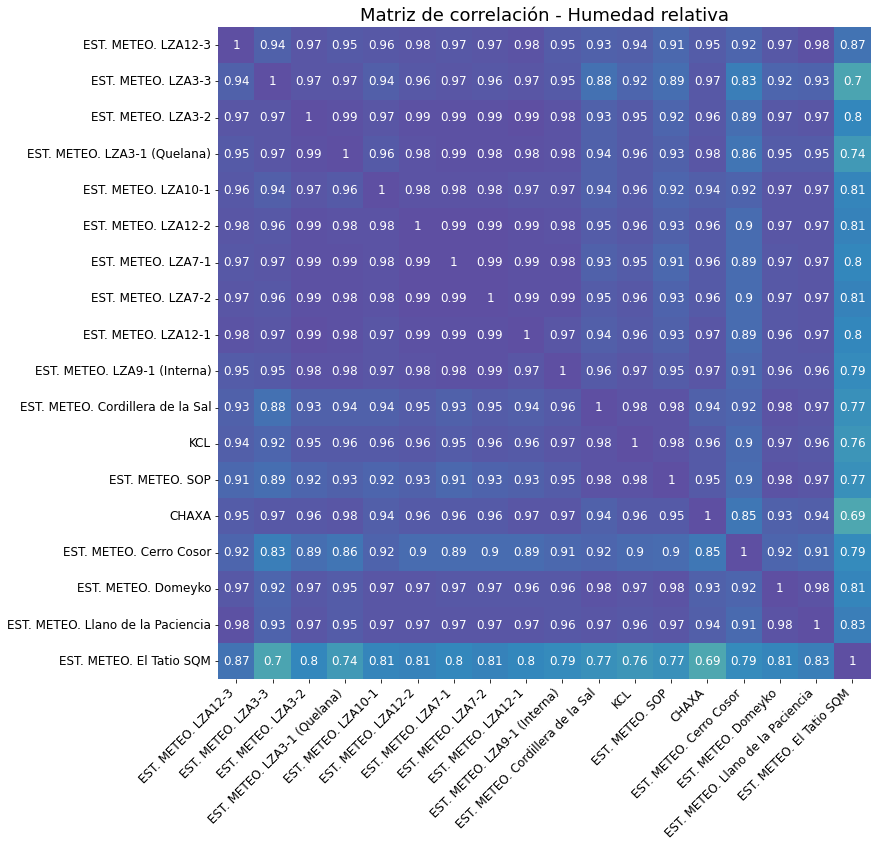

In [9]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.heatmap(
    a2,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Humedad relativa", size="18")
name = "MCorrHR"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)

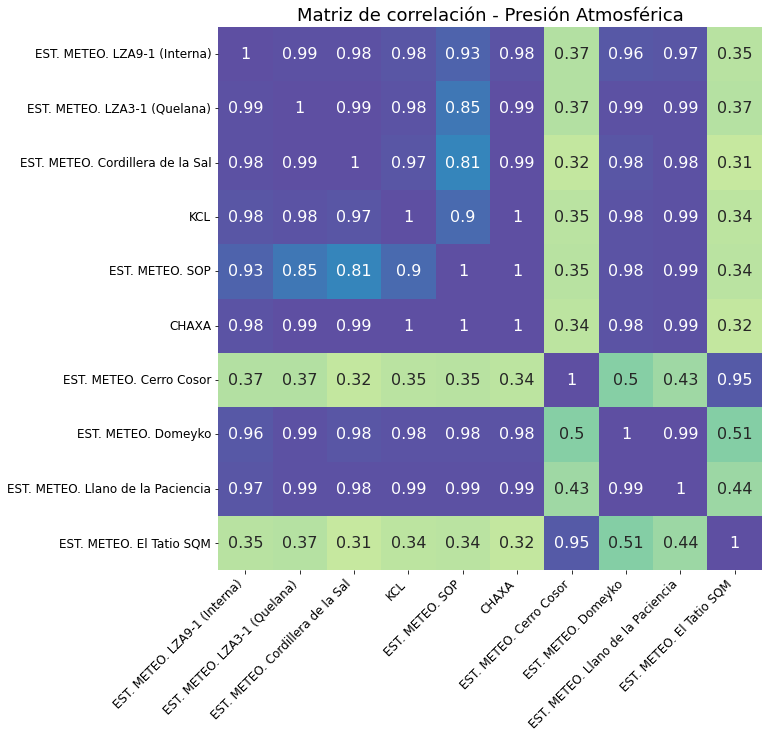

In [10]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(
    a3,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Presión Atmosférica", size="18")
name = "MCorrPAtm"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)


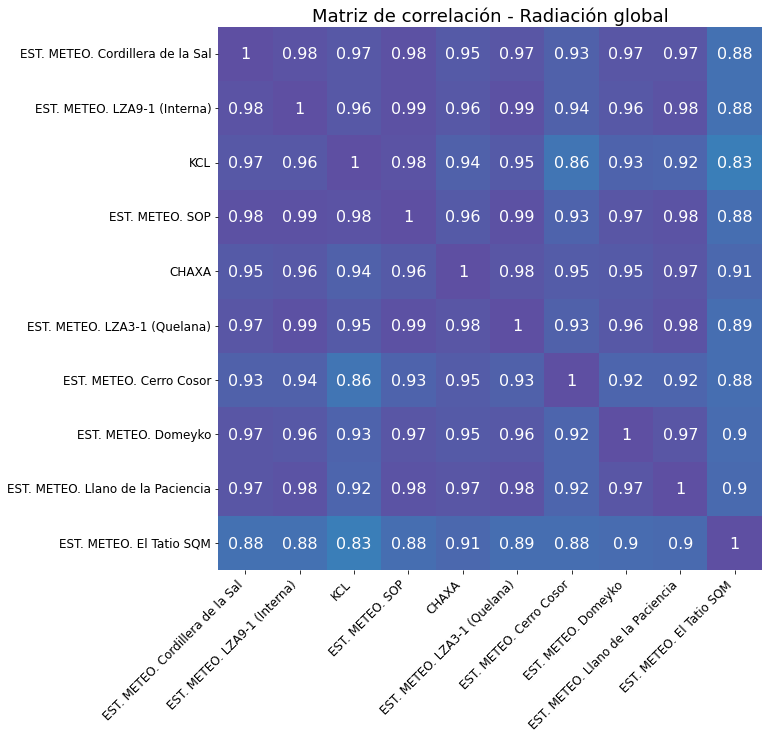

In [11]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(
    a4,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Radiación global", size="18")
name = "MCorrRadGlo"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)


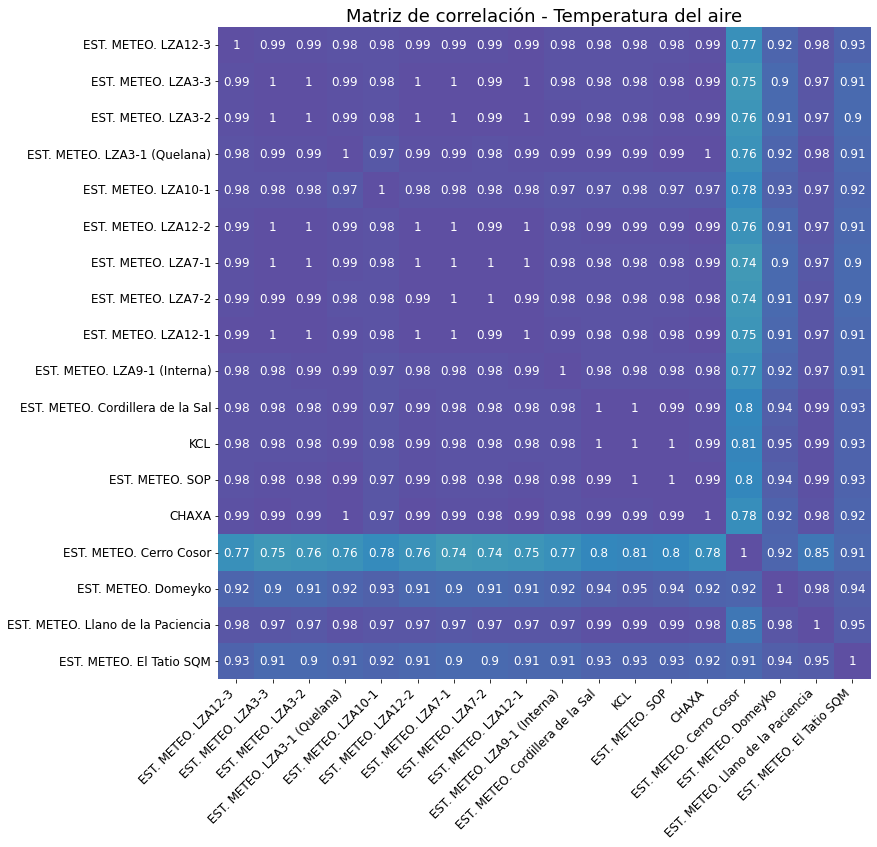

In [12]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.heatmap(
    a5,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Temperatura del aire", size="18")
name = "MCorrTaire"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)


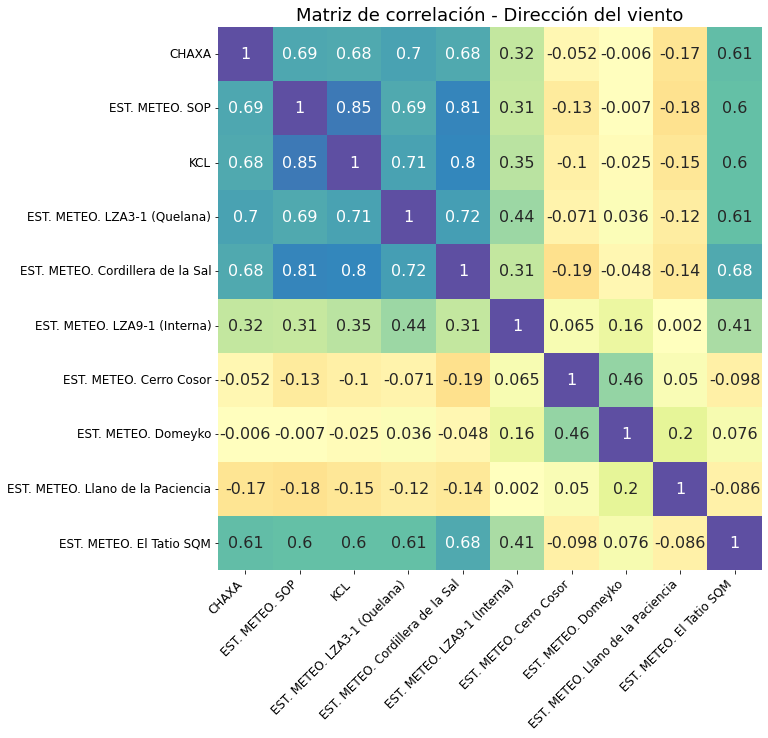

In [13]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(
    a6,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Dirección del viento", size="18")
name = "MDirViento"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)


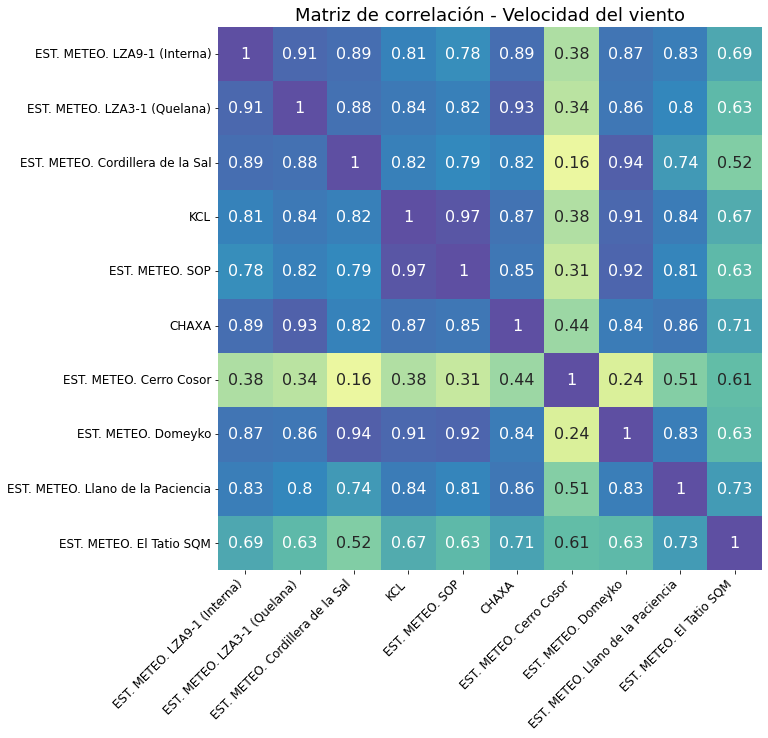

In [14]:
#CORRELACION EVAPORACION
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(
    a7,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("Spectral", as_cmap=True),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 12)
ax.set_title("Matriz de correlación - Velocidad del viento", size="18")
name = "MCorrVelViento"
plt.savefig(rutaSalida + name + datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')+".jpg",  bbox_inches = 'tight', pad_inches = 0.25, dpi=300)
